<a href="https://colab.research.google.com/github/lukaszplust/NUMERICAL_METHODS/blob/main/Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lu_factor, lu_solve

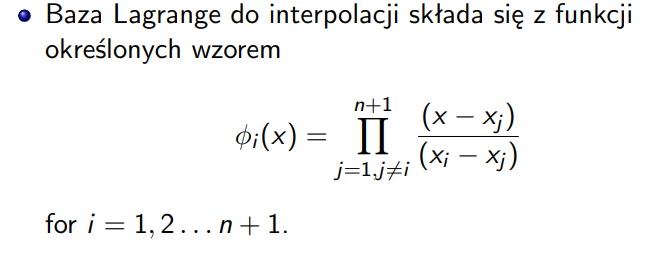

In [3]:
def lagrange_interpolate(point_x,point_y,x):
  value_interpolated = 0
  n = len(point_x)
  for i in range(n):
    fi = 1
    for j in range(n):
      if i != j:
        fi *= (x - point_x[j]) / (point_x[i] - point_x[j]) #tu może jeszcze powinno być 1.0 * przed nawiasem
    value_interpolated += (fi * point_y[i])
  return value_interpolated

In [4]:
def lagrange(value_x, point_x, point_y):
    return [lagrange_interpolate(point_x, point_y, x) for x in value_x]

In [5]:
def spline_interpolate_point(nodes_x, factors, x):
    for i, node_x in enumerate(nodes_x[:-1]):
        next_node_x = nodes_x[i + 1]
        if node_x <= x <= next_node_x:
            h = x - node_x
            interpolated_value = sum(factors[4 * i + j] * h ** j for j in range(4))
            return interpolated_value
    return 0

In [88]:
def spline(input_x, nodes_x, nodes_y):
    
    n = len(nodes_x)  # ilość węzłów
    
    matrix_size = 4 * (n-1)

    A, b = np.zeros((matrix_size, matrix_size)), np.zeros(matrix_size)
    pdb.set_trace()
    #nodes_x = xi
    for i in range(0, n-1):
        h = nodes_x[i + 1] - nodes_x[i]
        # Si(xi) = f(xi)
        #(1)
        # a0+b0(x0−x0)+c0(x0−x0)2+d0(x0−x0)3 =f(x0) -> a0 =f(x0)
        A[4*i][4*i] = 1
    
        b[4*i] = nodes_y[i]#ustawiam a0, pozniej a1

        # Si(xi+1) = f(xi+1)

        # a0+b0h+c0h2+d0h3 =f(x1)
        A[4 * i + 1][4 * i] = 1 #a0 w 1 wierszu (i tam jest 1)
        A[4 * i + 1][4 * i + 1] = h # h dla b0 w drugim wierszu
        A[4 * i + 1][4 * i + 2] = h * h# h^2 dla c0 w 3 wierszu
        A[4 * i + 1][4 * i + 3] = h * h * h # h^3 dla d0 w 4 wierszu
        b[4 * i + 1] = nodes_y[i + 1]# i teraz ustawiam wartosc w b0?? A DLACZEGO JUZ NIE W C0 D0 !!!!!!

        if i > 0:
            h = nodes_x[i] - nodes_x[i - 1]
            # S'i-1(xi) = S'i(xi)
            # b0 + 2c0h + 3d0h2 = b1
            A[4 * i + 2][4 * (i-1) + 1] = 1
            A[4 * i + 2][4 * (i-1) + 2] = 2 * h
            A[4 * i + 2][4 * (i-1) + 3] = 3 * h * h
            A[4 * i + 2][4 * i + 1] = -1
            # S''i-1(xi) = S''i(xi)
            # 2c0 + 6d0h = 2c1
            A[4 * i + 3][4 * (i - 1) + 2] = 2
            A[4 * i + 3][4 * (i - 1) + 3] = 6 * h
            A[4 * i + 3][4 * i + 2] = -2
    # Na krawędziach
    # S''0(x0) = 0
    A[2][2] = 2
    # S''n-1(xn) = 0
    h = nodes_x[n-1] - nodes_x[n-2]
    A[3][4 * (n - 1 - 1) + 2] = 2
    A[3][4 * (n - 1 - 1) + 3] = 6 * h
    
    #pdb.set_trace()
    lu, piv = lu_factor(A)
    factors = lu_solve((lu, piv), b)
    interpolated_values = []
    interpolated_x = []
    #pdb.set_trace()
    for xp in input_x:
        if nodes_x[0] <= xp <= nodes_x[-1]:
            interpolated_values.append(spline_interpolate_point(nodes_x, factors, xp))
            interpolated_x.append(xp)
       
    return interpolated_x, interpolated_values

Creating plot for spline method

In [89]:
def spline_plot(value_x, value_y, point_x, point_y, interpolated_x, interpolated_y):
    plt.yscale('log')
    plt.plot(value_x, value_y, '-', color = 'blue', label='Próbki')
    plt.plot(interpolated_x, interpolated_y,color = 'green', label='F(x) interpoled')
    plt.plot(point_x, point_y, 'o',color = 'orange' ,label='nodes')

    plt.title(f"Spline_Interpolation for: {str(len(point_x))} nodes")
    plt.xlabel('distance [m]')
    plt.ylabel('height [m.n.p.m]')
    plt.legend()

    save_name = f"Spline_Interpolation for {len(point_x)} nodes.png"
    plt.savefig(save_name)
    plt.show()

Creating plot fot lagrange method

In [90]:
def plot_lagrange(value_x, value_y, point_x, point_y, interpolated_x, interpolated_y):
  plt.yscale('log')
  plt.plot(value_x, value_y, '-',color ='blue', label = 'samples')#
  plt.plot(interpolated_x,interpolated_y, color ='green',label = "F(x) interpoled")#funkcja interpolujaca
  plt.plot(point_x, point_y,'o',color ='orange',label = 'nodes')#wezly

  plt.title(f"Lagrange_Interpolation for: {str(len(point_x))} nodes")
  plt.xlabel('distance [m]')
  plt.ylabel('height [m.n.p.m]')
  plt.legend()

  save_name = f"Lagrange_Interpolation for {len(point_x)} nodes.png"
  plt.savefig(save_name)
  plt.show()

In [91]:
import pdb
#df = pd.read_csv('SpacerniakGdansk.csv')
df = pd.read_csv('MountEverest.csv')
size = df.shape[0]# len(df.index), sample_size
nodes = [3,4,8,10,15,25,30,40]

for node in nodes:

  nodes_distance = []
  nodes_height = []

  intervals = node - 1# interwal node - 1
  x = 1#x to odestep pomiedzy wezłami interpolacji
  
  while intervals * (x + 1) < size:
    x += 1
  first_node = 0
  while (first_node + 1) < (size - 1 - (first_node + intervals*x)):#zapewniam, ze odstep miedzy wezlami interpolacji jest odpowiednio dostsowoany do rozmiaru danych wejsciowych
    first_node += 1
  x_index = [first_node]
  for i in range(1, node):
    x_index.append(first_node + i * x)


  value_distance = df.iloc[:, 0].tolist()  # input distance
  value_height = df.iloc[:, 1].tolist()  # input height


  for i in x_index:
    nodes_distance.append(value_distance[i])
    nodes_height.append(value_height[i])

  interpolated_lagrange = lagrange(value_distance, nodes_distance, nodes_height)
  x_for_interpolation, interpolated_values_spline = spline(value_distance, nodes_distance, nodes_height)
  
  #plot_lagrange(value_distance,value_height,nodes_distance, nodes_height,value_distance,interpolated_lagrange)
  spline_plot(value_distance, value_height, nodes_distance, nodes_height, x_for_interpolation, interpolated_values_spline)

> <ipython-input-88-57d7bd129186>(10)spline()
      8     pdb.set_trace()
      9     #nodes_x = xi
---> 10     for i in range(0, n-1):
     11         h = nodes_x[i + 1] - nodes_x[i]
     12         # Si(xi) = f(xi)

ipdb> n
> <ipython-input-88-57d7bd129186>(11)spline()
      9     #nodes_x = xi
     10     for i in range(0, n-1):
---> 11         h = nodes_x[i + 1] - nodes_x[i]
     12         # Si(xi) = f(xi)
     13         #(1)

ipdb> n
> <ipython-input-88-57d7bd129186>(15)spline()
     13         #(1)
     14         # a0+b0(x0−x0)+c0(x0−x0)2+d0(x0−x0)3 =f(x0) -> a0 =f(x0)
---> 15         A[4*i][4*i] = 1
     16 
     17         b[4*i] = nodes_y[i]#ustawiam a0, pozniej a1

ipdb> n
> <ipython-input-88-57d7bd129186>(17)spline()
     15         A[4*i][4*i] = 1
     16 
---> 17         b[4*i] = nodes_y[i]#ustawiam a0, pozniej a1
     18 
     19         # Si(xi+1) = f(xi+1)

ipdb> p(A)
array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0.